# **In *silico* categorization of arrhythmia subtypes from ECG recordings.**

In [1]:
import os
import pywt
import time
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils import resample
from keras.models import Sequential
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from keras.layers import Dense, Activation
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D

tf.random.set_seed(42)
np.random.seed(42)

## **Load Data**

In [2]:
# view all files in the dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv
/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv


## BIH-Arrhythmia Dataset
Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

* **Number of Samples:** 109446
* **Number of Categories:** 5
* **Sampling Frequency:** 125Hz
* **Data Source:** Physionet's MIT-BIH Arrhythmia Dataset (https://physionet.org/content/mitdb/1.0.0/)
* **Classes:**
    *     Non-ecotic beats (normal beat) ('N'): 0
    *     Supraventricular ectopic beats ('S'): 1
    *     Ventricular ectopic beats ('V'): 2
    *     Fusion Beats ('F'): 3
    *     Unknown Beats ('Q'): 4

In [3]:
# import MIT-BIH Arrhythmia Data
data_train = pd.read_csv('../input/heartbeat/mitbih_train.csv',header=None)
data_test = pd.read_csv('../input/heartbeat/mitbih_test.csv',header=None)

In [4]:
# check class labels of BIH dataset
print("BIH train class label: " + str(list(data_train[data_train.columns[-1]].unique())))
print("BIH test class label: " + str(list(data_test[data_test.columns[-1]].unique())))

BIH train class label: [0.0, 1.0, 2.0, 3.0, 4.0]
BIH test class label: [0.0, 1.0, 2.0, 3.0, 4.0]


In [5]:
# shuffle the DataFrame rows 
data_train = data_train.sample(frac = 1)
data_test = data_test.sample(frac = 1)

## **Exploratory analysis**

In [6]:
print("Training dataset shape:")
print(data_train.shape)
print("Test dataset shape:")
print(data_test.shape)

Training dataset shape:
(87554, 188)
Test dataset shape:
(21892, 188)


In [7]:
data_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


Each feature values ranges between zero and one. The last column contains the class label.

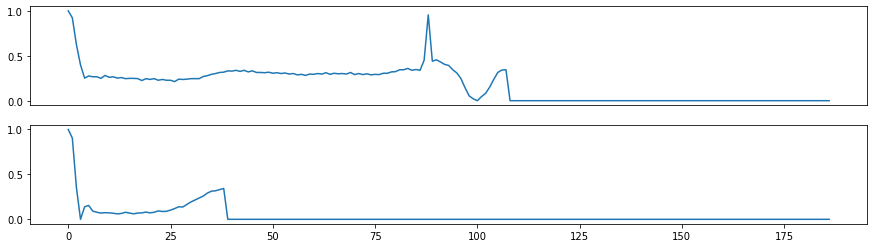

In [8]:
# plot two randomly selected ECG data from the training set
plt.figure(figsize=(15,4))
plt.subplot(211)
plt.plot(data_train.iloc[random.randint(0,len(data_train)),:187])
plt.gca().axes.get_xaxis().set_ticks([])
plt.subplot(212)
plt.plot(data_train.iloc[random.randint(0,len(data_train)),:187])
plt.show()

From the figure above it can be observed that all recordings are not of the same length, and are zero padded.

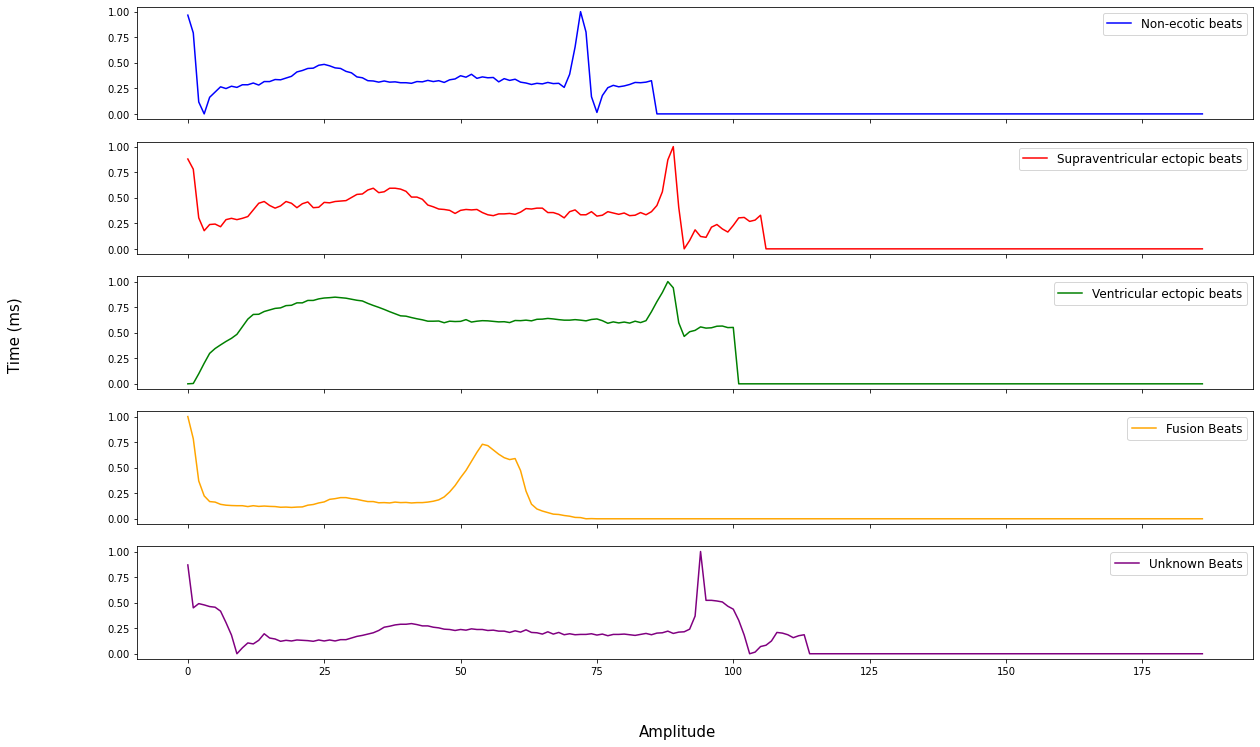

In [9]:
# plot ECG data belonging to each class label
label = ["Non-ecotic beats","Supraventricular ectopic beats","Ventricular ectopic beats",
         "Fusion Beats","Unknown Beats"]
color = ['blue','red','green','orange','purple','black']
fig, ax = plt.subplots(5, 1, sharex=True, sharey=True,figsize=(20,12))
for i, row in enumerate(ax):
    row.plot((data_train[data_train[187] == i].iloc[0])[:-1], label=label[i], color=color[i])
    row.legend(fontsize=12)
fig.text(0.5, 0.04, 'Amplitude', va='center', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Time (ms)', va='center', ha='center', rotation='vertical', fontsize=15)

plt.show()

In [10]:
# display number of records in each category
data_train[data_train.columns[-1]].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

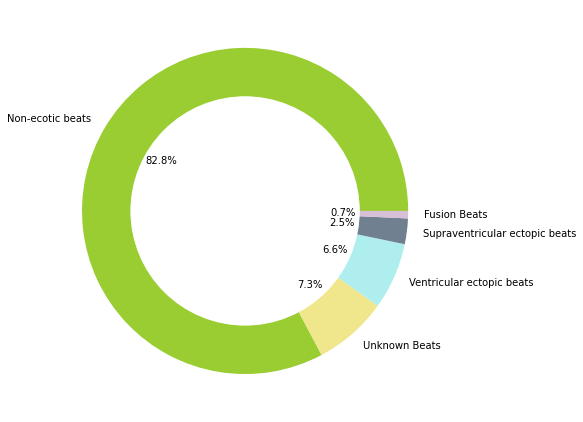

In [11]:
# plot number of records in each category
plt.figure(figsize=(15,7.5))
plt.pie(data_train[187].value_counts(), labels=['Non-ecotic beats','Unknown Beats','Ventricular ectopic beats',
                                                'Supraventricular ectopic beats','Fusion Beats'],
        colors=['yellowgreen','khaki','paleturquoise','slategrey','thistle'],autopct='%2.1f%%')
p=plt.gcf()
p.gca().add_artist(plt.Circle( (0,0), 0.7, color='white'))
plt.show()

## **Dealing with imbalanced data**

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is the performance on the minority class that is most important.

One approach to address this problem is to oversample the examples in the minority class. The simplest approach involves duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model. An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique (SMOTE). This technique was described by **Nitesh Chawla, et al.** in their 2002 paper *“SMOTE: Synthetic Minority Over-sampling Technique.”*

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbours for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

Refer: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [12]:
steps = [('o', SMOTE(sampling_strategy=0.5)), ('u', RandomUnderSampler(sampling_strategy=0.7))]
pipeline = Pipeline(steps=steps)

In [13]:
def balance(train,df_0):
    data, label = [0] * len(set(list(train[train.columns[-1]]))), [0] * len(set(list(train[train.columns[-1]])))
    for i in set(list(train[train.columns[-1]])):
        if i == 0.0:
            continue
        else:
            df = train[train[train.columns[-1]] == i]

        train_df = pd.concat([df_0,df])
        X = train_df[train_df.columns[:-1]]
        y = train_df[train_df.columns[-1]]
        # transform the dataset
        X, y = pipeline.fit_resample(X, y)
        
        data[int(i)] = X[y==i]
        label[int(i)] = y[y==i]
    return data, label, X, y

df_0 = data_train[data_train[data_train.columns[-1]] == 0].sample(n=20000,random_state=42)
temp, temp_l, X, y = balance(data_train,df_0)

In [14]:
X_train = X[y==0]
y_train = y[y==0]
for i in range(1,len(temp)):
    X_train = pd.concat([X_train,temp[i]])
    y_train = pd.concat([y_train,pd.Series(np.array(temp_l[i]))])

In [15]:
X_train.shape, y_train.shape

((54285, 187), (54285,))

In [16]:
# display number of records in each category
y_train.value_counts()

0.0    14285
3.0    10000
4.0    10000
2.0    10000
1.0    10000
dtype: int64

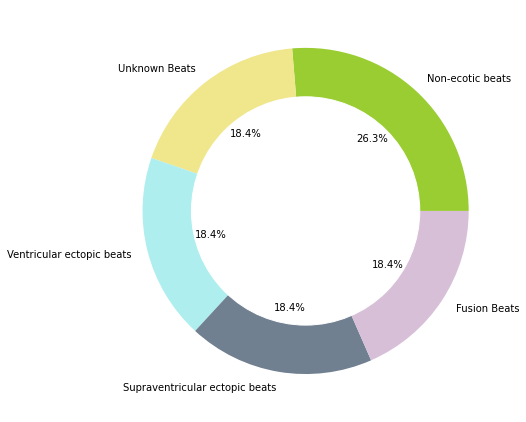

In [17]:
# plot number of records in each category
plt.figure(figsize=(15,7.5))
plt.pie(y_train.value_counts(),labels=['Non-ecotic beats','Unknown Beats','Ventricular ectopic beats',
                                       'Supraventricular ectopic beats','Fusion Beats'],
        colors=['yellowgreen','khaki','paleturquoise','slategrey','thistle'],autopct='%2.1f%%')
p=plt.gcf()
p.gca().add_artist(plt.Circle( (0,0), 0.7, color='white'))
plt.show()

In [18]:
X_test = data_test[data_test.columns[:-1]]
y_test = data_test[data_test.columns[-1]]
X_test, y_test = shuffle(X_test, y_test)
X_test.shape, y_test.shape

((21892, 187), (21892,))

## Baseline model

Several methods have been proposed in the past to automatically classify heartbeats from ECG signals, these includes Fourier transform, principle component analysis, wavelet transform, and the hidden Markov method. Moreover, machine learning methods, such as artificial neural networks (ANNs), support vector machines (SVMs), least squares support vector machines (LS-SVMs), particle swarm optimization support vector machines (PSO-SVMs), particle swarm optimization radial basis functions (PSO-RBFs), and extreme learning machines (ELMs), have also been developed for the accurate classification of heartbeats.

However, there are some drawbacks to these classification methods. For example, expert systems require a large amount of prior knowledge, which may vary for different patients. Another problem lies in the manual feature selection of the heartbeat signal for some machine learning methods. ECG feature extraction is a key technique for heartbeat recognition, which is used to select a representative feature subset from the raw ECG signal. However, manual selection may result in the loss of information. Moreover, methods like the PCA and Fourier transform may increase the complexity and computational time required to identify a solution. As the number of patients increases, the classification accuracy will decrease due to the large variation in the patterns of the ECG signals among different patients.

In [19]:
start_time = time.time()
model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
model.fit(X_train, y_train)
Pipeline(steps=[('standardscaler', StandardScaler()),('svc', SVC(gamma='auto'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [20]:
y_pred = model.predict(X_test)
print("Accuracy: ",sum(y_test == y_pred)/len(y_test)*100,'%')
print("Execution time: ", (time.time() - start_time)/60,'minutes')

Accuracy:  92.60460442170655 %
Execution time:  5.811240474383037 minutes


## **Model preparation and training**

In [21]:
# run a deep feed forward neural network
start_time = time.time()
scaler = StandardScaler()

def create_model():
    model = keras.models.Sequential([
        keras.layers.Dense(100, input_shape=(187,), kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(200, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(50, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(5, activation="softmax")
    ])
    model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# wrap the model using the function you created
clf = KerasClassifier(create_model, epochs=40, callbacks=callbacks, batch_size=32)

pipeline = Pipeline([('preprocess',scaler),('clf',clf)])

pipeline.fit(X_train, y_train)

Epoch 1/40
1697/1697 [==============================] - 6s 4ms/step - loss: 0.3297 - accuracy: 0.8812
Epoch 2/40
1697/1697 [==============================] - 6s 4ms/step - loss: 0.1820 - accuracy: 0.9357
Epoch 3/40
1697/1697 [==============================] - 6s 3ms/step - loss: 0.1403 - accuracy: 0.9508
Epoch 4/40
1697/1697 [==============================] - 6s 4ms/step - loss: 0.1190 - accuracy: 0.9583
Epoch 5/40
1697/1697 [==============================] - 6s 4ms/step - loss: 0.1033 - accuracy: 0.9638
Epoch 6/40
1697/1697 [==============================] - 6s 3ms/step - loss: 0.0895 - accuracy: 0.9692
Epoch 7/40
1697/1697 [==============================] - 6s 3ms/step - loss: 0.0825 - accuracy: 0.9720
Epoch 8/40
1697/1697 [==============================] - 6s 4ms/step - loss: 0.0763 - accuracy: 0.9744
Epoch 9/40
1697/1697 [==============================] - 6s 3ms/step - loss: 0.0733 - accuracy: 0.9749
Epoch 10/40
1697/1697 [==============================] - 6s 3ms/step - loss: 0.065

Pipeline(steps=[('preprocess', StandardScaler()),
                ('clf',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7daf991350>)])

In [22]:
y_pred = pipeline.predict(X_test)
print("Accuracy: ",sum(y_test == y_pred)/len(y_test)*100,'%')
print("Execution time: ", (time.time() - start_time)/60,'minutes')

Accuracy:  96.82532431938607 %
Execution time:  3.881602362791697 minutes


### **Why a convolution neural network over feed forward neural network?**
Convolutional neural networks (CNN) are useful tools that have been used in pattern recognition applications, such as the classification of handwriting and object recognition in large archives. The connectivity between neurons in a CNN is similar to the organization of the visual cortex in animals, which makes CNNs superior to other methods in the recognition of the pattern and structure of items. CNN also provide a number of advantages over conventional classification techniques in biomedical applications. They are a specialized type of neural network with an inherent grid-like topology for processing input data in which nearby entries are correlated.

A CNN is able to successfully capture the spatial and temporal dependencies in an image through the application of relevant filters. The architecture performs a better fitting to the image dataset due to the reduction in the number of parameters involved and reusability of weights. In other words, the network can be trained to understand the sophistication of the image better.

In [23]:
# convert labels to one hot encoded values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
# frame the training and test data a 3D matrix
X_train = np.asarray(X_train)
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = np.asarray(X_test)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [25]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (54285, 187, 1)
y_train (54285, 5)
X_test (21892, 187, 1)
y_test (21892, 5)


In [26]:
# run a convolution neural network
start_time = time.time()

model = Sequential()
model.add(Convolution1D(32, (6), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=(3), strides=(2), padding="same"))
model.add(Convolution1D(64, (3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2), strides=(2), padding="same"))
model.add(Convolution1D(32, (2), activation='relu'))
model.add(MaxPooling1D(pool_size=(2), strides=(2), padding="same"))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='softmax'))
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='cnn_best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32)
model.load_weights('cnn_best_model.h5')

Epoch 1/40
1697/1697 [==============================] - 17s 10ms/step - loss: 0.4026 - accuracy: 0.8533
Epoch 2/40
1697/1697 [==============================] - 17s 10ms/step - loss: 0.1873 - accuracy: 0.9335
Epoch 3/40
1697/1697 [==============================] - 17s 10ms/step - loss: 0.1297 - accuracy: 0.9551
Epoch 4/40
1697/1697 [==============================] - 19s 11ms/step - loss: 0.1007 - accuracy: 0.9644
Epoch 5/40
1697/1697 [==============================] - 17s 10ms/step - loss: 0.0796 - accuracy: 0.9721
Epoch 6/40
1697/1697 [==============================] - 18s 11ms/step - loss: 0.0696 - accuracy: 0.9757
Epoch 7/40
1697/1697 [==============================] - 17s 10ms/step - loss: 0.0579 - accuracy: 0.9802
Epoch 8/40
1697/1697 [==============================] - 18s 10ms/step - loss: 0.0518 - accuracy: 0.9817
Epoch 9/40
1697/1697 [==============================] - 18s 11ms/step - loss: 0.0460 - accuracy: 0.9841
Epoch 10/40
1697/1697 [==============================] - 18s 10m

OSError: Unable to open file (unable to open file: name = 'cnn_best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
print('Test accuracy is: %.2f%%' %(model.evaluate((X_test),y_test)[1]*100))
print("Execution time: ", (time.time() - start_time)/60,'minutes')

685/685 [==============================] - 3s 4ms/step - loss: 0.2083 - accuracy: 0.9736
Test accuracy is: 97.36%
Execution time:  11.948495535055796 minutes


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 182, 32)           224       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 91, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 89, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 32)            4128      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 704)              

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[17741,   230,   101,    32,    14],
       [   76,   464,     9,     6,     1],
       [   30,     9,  1387,    17,     5],
       [   10,     2,    15,   135,     0],
       [   15,     1,     6,     0,  1586]])

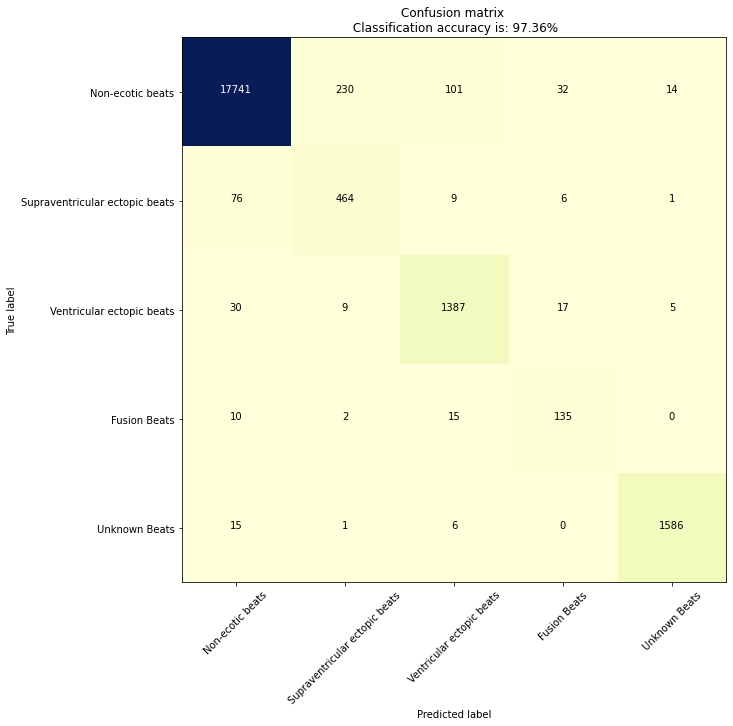

In [30]:
# Plot non-normalized confusion matrix
def plot_confusion_matrix(cm, classes,normalize=False,cmap="YlGnBu"):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    acc = "{:.2f}".format(np.trace(cnf_matrix)/np.sum(cnf_matrix)*100)
    plt.title('Confusion matrix \n Classification accuracy is: ' + str(acc)+'%')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=label,normalize=False)
plt.show()

In [31]:
y_pred = model.predict(X_test)

In [32]:
y_temp = np.argmax(y_pred, axis=1)
y_real = np.argmax(y_test, axis=1)
precision,recall,fscore,support = precision_recall_fscore_support(y_real, y_temp, average='weighted')
print('Precision : %.3f%%' % (precision*100))
print('Recall : %.3f%%' % (recall*100))
print('F1 score : %.3f%%' % (fscore*100))

Precision : 97.646%
Recall : 97.355%
F1 score : 97.463%
